In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
import numpy as np
from lifelines import KaplanMeierFitter 


# Download the stopwords corpus
nltk.download('stopwords')
PATH = os.getcwd()
data_path = PATH + "/data/"

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gabemiller/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Load patients data
patients = pd.read_csv(data_path + 'PATIENTS.csv.gz')
patients.columns = [col.lower() for col in patients.columns]

In [3]:
# Load admissions data
admissions = pd.read_csv(data_path + 'ADMISSIONS.csv.gz')
admissions.columns = [col.lower() for col in admissions.columns]

In [4]:
# Load diagnoses_icd data
diagnoses = pd.read_csv(data_path + 'DIAGNOSES_ICD.csv.gz')
diagnoses.columns = [col.lower() for col in diagnoses.columns]

In [5]:
# Load ICUSTAYS data
icustays = pd.read_csv(data_path + 'ICUSTAYS.csv.gz')
icustays.columns = [col.lower() for col in icustays.columns]

In [6]:
# Load D_ICD_DIAGNOSES data
diagnoses_labels = pd.read_csv(data_path + 'D_ICD_DIAGNOSES.csv.gz')
diagnoses_labels.columns = [col.lower() for col in diagnoses_labels.columns]

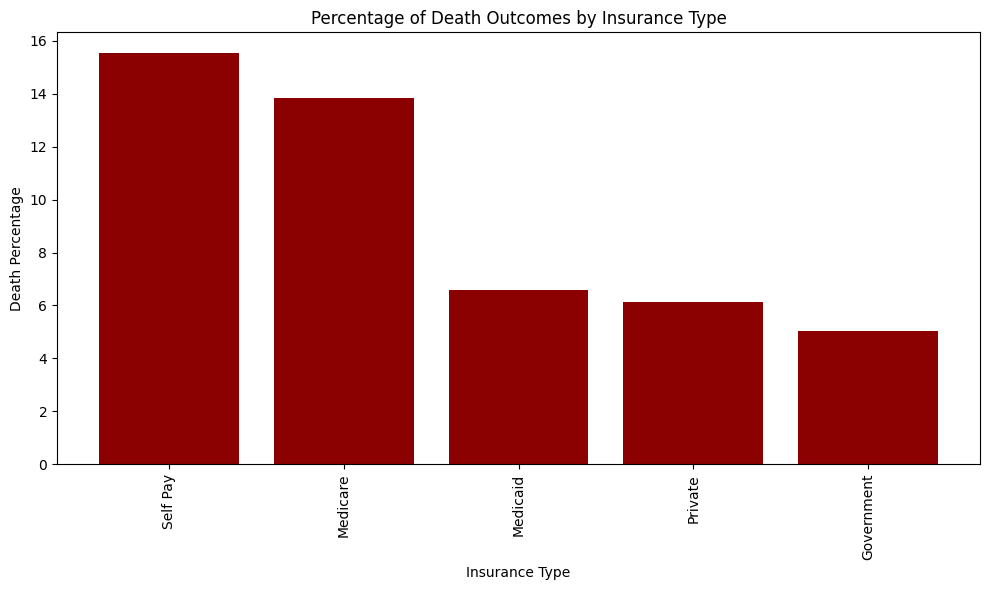

In [23]:
"""Visualization 1: Count of deaths based on insurance"""
# Step 1: Calculate total admissions for each insurance type
total_admissions_by_insurance = admissions.groupby('insurance').size().reset_index(name='total_admissions')

# Step 2: Filter rows where deathtime is not null (indicating a death occurred)
deaths = admissions[admissions['deathtime'].notnull()]

# Step 3: Calculate the number of deaths for each insurance type
death_counts_by_insurance = deaths.groupby('insurance').size().reset_index(name='death_count')

# Step 4: Merge the total admissions and death counts into one DataFrame
insurance_stats = pd.merge(total_admissions_by_insurance, death_counts_by_insurance, on='insurance', how='left')

# Fill NaN values in death_count with 0 (in case some insurance types have no deaths)
insurance_stats['death_count'] = insurance_stats['death_count'].fillna(0)

# Step 5: Calculate the percentage of deaths per insurance type
insurance_stats['death_percentage'] = (insurance_stats['death_count'] / insurance_stats['total_admissions']) * 100

# Step 6: Sort by death percentage for better visualization
insurance_stats = insurance_stats.sort_values(by='death_percentage', ascending=False)

# Plot the bar graph of death percentage by insurance type
plt.figure(figsize=(10, 6))
plt.bar(insurance_stats['insurance'], insurance_stats['death_percentage'], color='darkred')

# Rotate the x labels for better readability
plt.xticks(rotation=90)

# Add labels and title
plt.xlabel('Insurance Type')
plt.ylabel('Death Percentage')
plt.title('Percentage of Death Outcomes by Insurance Type')

# Display the bar chart
plt.tight_layout()
plt.show()


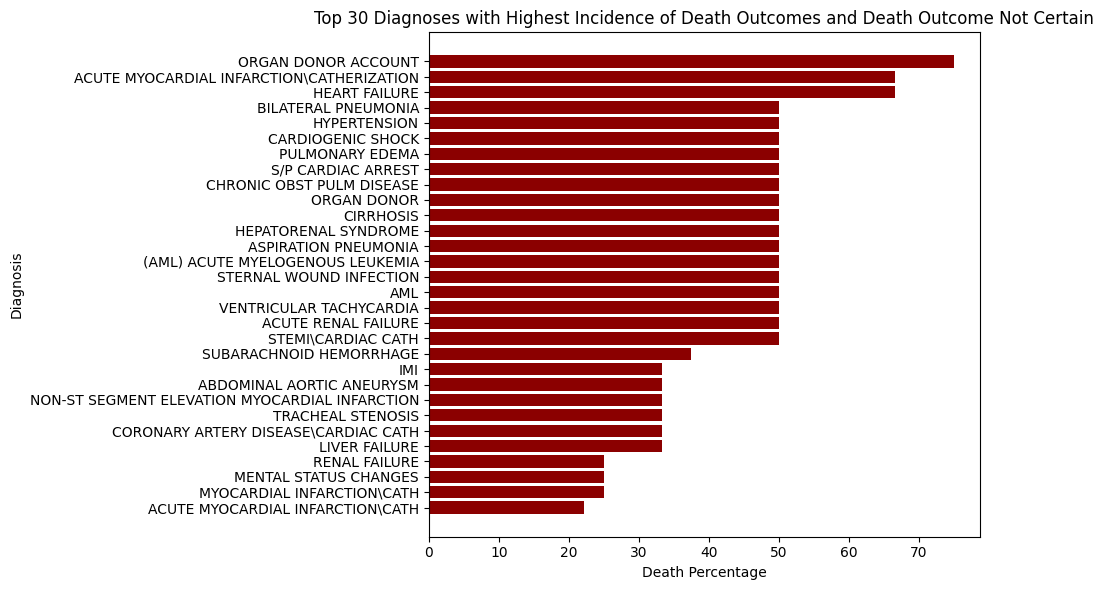

In [43]:
"""Visualization 2: Diagnoses with highest incidence of death"""
# Step 1: Filter rows where deathtime is not null (indicating a death occurred)
admissions_curr = admissions[admissions['admission_type'] == 'URGENT']
deaths = admissions_curr[admissions_curr['deathtime'].notnull()]

# Step 2: Group by diagnosis and count the number of deaths
death_counts_by_diagnosis = deaths.groupby('diagnosis').size().reset_index(name='death_count')

# Step 3: Count total admissions for each diagnosis
total_counts_by_diagnosis = admissions_curr.groupby('diagnosis').size().reset_index(name='total_count')

# Step 4: Merge death counts and total counts into one DataFrame
diagnosis_stats = pd.merge(total_counts_by_diagnosis, death_counts_by_diagnosis, on='diagnosis', how='left')

# Fill NaN values in death_count with 0 (for diagnoses with no deaths)
diagnosis_stats['death_count'] = diagnosis_stats['death_count'].fillna(0)

# Step 5: Calculate the percentage of deaths per diagnosis
diagnosis_stats['death_percentage'] = (diagnosis_stats['death_count'] / diagnosis_stats['total_count']) * 100

# Step 6: Sort by death percentage to identify diagnoses with the highest incidence of death
diagnosis_stats = diagnosis_stats.sort_values(by='death_percentage', ascending=False)

num_keep = 30

# Step 7: Keep only the top n diagnoses with the highest death percentages and or filter out certain cases based on death percentage
top_diagnoses = diagnosis_stats[diagnosis_stats['death_percentage'] < 100]
top_diagnoses = top_diagnoses.head(num_keep)

# Step 8: Plot the bar graph of death percentage by diagnosis
plt.figure(figsize=(10, 6))
plt.barh(top_diagnoses['diagnosis'], top_diagnoses['death_percentage'], color='darkred')

# Add labels and title
plt.xlabel('Death Percentage')
plt.ylabel('Diagnosis')
plt.title(f'Top {num_keep} Diagnoses with Highest Incidence of Death Outcomes where Death Outcome Not Certain')

# Invert the y-axis to show the highest death percentage at the top
plt.gca().invert_yaxis()

# Display the bar chart
plt.tight_layout()
plt.show()

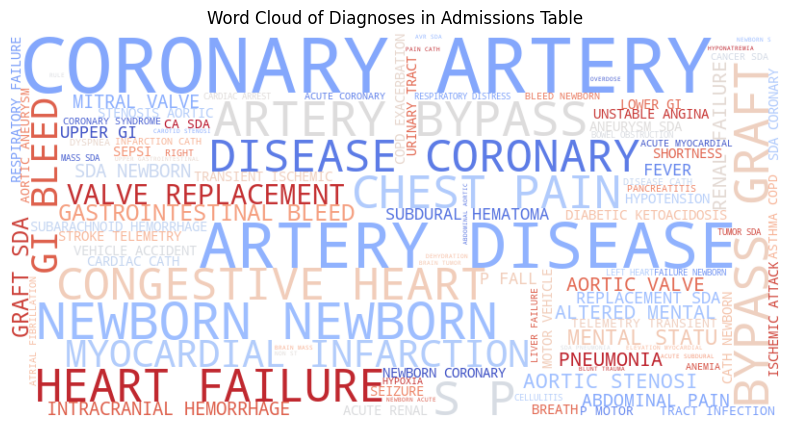

In [46]:
"""Visuaization 3a: Word cloud of admissions diagnoses"""

# Step 1: Get all diagnoses descriptions from the 'diagnosis' column
diagnosis_descriptions = ' '.join(admissions['diagnosis'].dropna().astype(str).tolist())

# Step 2: Create the word cloud for the diagnosis descriptions
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100, colormap='coolwarm').generate(diagnosis_descriptions)

# Step 3: Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Diagnoses in Admissions Table')
plt.show()


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gabemiller/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


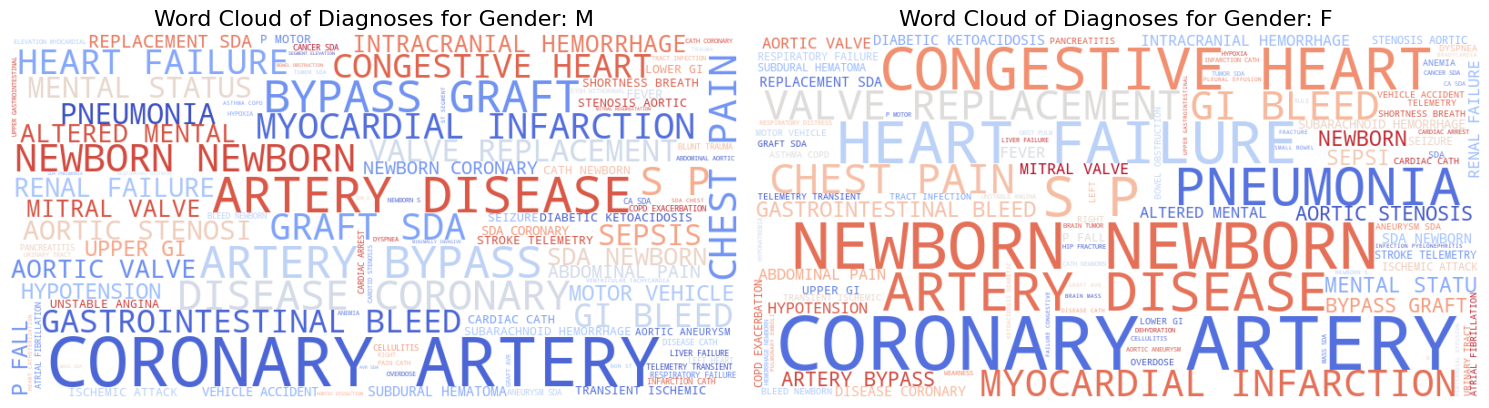

In [49]:
"""Visualization 3b: Word cloud of diagnoses stratifying on gender"""

# Step 1: Merge admissions and patients DataFrames based on 'subject_id'
merged_data = pd.merge(admissions, patients[['subject_id', 'gender']], on='subject_id', how='left')

# Step 2: Define custom stopwords or terms to remove
stop_words = set(stopwords.words('english') + ['disease', 'disorder', 'syndrome', 'acute', 'chronic', 'unspecified'])

# Step 3: Prepare the subplots for side-by-side display
fig, axes = plt.subplots(1, 2, figsize=(15, 7))  # Create two subplots in one row

# Step 4: Filter by gender and generate word clouds
for i, gender in enumerate(['M', 'F']):
    # Get diagnoses for the current gender
    gender_data = merged_data[merged_data['gender'] == gender]

    # Get all diagnosis descriptions
    diagnosis_descriptions = ' '.join(gender_data['diagnosis'].dropna().astype(str).tolist())

    # Clean the diagnosis descriptions by removing stopwords
    cleaned_diagnosis_descriptions = ' '.join([word for word in diagnosis_descriptions.split() if word.lower() not in stop_words])

    # Create the word cloud for the current gender
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100, colormap='coolwarm').generate(cleaned_diagnosis_descriptions)

    # Plot the word cloud on the respective subplot
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].axis('off')  # Turn off axis
    axes[i].set_title(f'Word Cloud of Diagnoses for Gender: {gender}', fontsize=16)

# Adjust layout to make sure everything fits
plt.tight_layout()
plt.show()


In [133]:
"""
Visualization 4/5: KM curve showing estimated survival probability over time for patients admitted for specific diagnosis
Includes overview of number of admissions for diagnosis of interest (visualization 4) AND km curve (visualization 5) 
indicating survival probability from time of first admission
"""
admissions['admittime'] = pd.to_datetime(admissions['admittime'])
admissions['deathtime'] = pd.to_datetime(admissions['deathtime'])

# Sort admissions by patient and admission time
admissions = admissions.sort_values(by=['subject_id', 'admittime'])

# Getting cases where same patient was re-admitted for the same diagnosis"""
duplicate_diagnoses = admissions[admissions.duplicated(['subject_id', 'diagnosis'], keep=False)]

In [134]:
"""Visualization 4/5: 
Finding diagnosis of interest: diagnosis where a patient example exists where they were re-admitted for a given diagnosis and survived, and another who died
"""
for diag in duplicate_diagnoses['diagnosis'].unique(): 
    dups_curr = duplicate_diagnoses[(duplicate_diagnoses['diagnosis'] == diag)]
    if dups_curr[(~dups_curr['deathtime'].isna())].shape[0] > 0 and dups_curr[(dups_curr['deathtime'].isna())].shape[0] > 0:
        print(diag)

SUBARACHNOID HEMORRHAGE
ABDOMINAL PAIN
SHORTNESS OF BREATH
PANCREATITIS
SEPSIS
PNEUMONIA
ALTERED MENTAL STATUS
CONGESTIVE HEART FAILURE
ANEMIA
UPPER GI BLEED
GASTROINTESTINAL BLEED
HYPOTENSION
LOWER GI BLEED
CHEST PAIN
CARDIAC ARREST
DIABETIC KETOACIDOSIS
ASTHMA;COPD EXACERBATION
FEVER
SUBDURAL HEMATOMA
SEIZURE
BACTEREMIA
CHRONIC OBST PULM DISEASE
HYPOXIA
LEFT HIP INFECTION
STROKE;TELEMETRY;TRANSIENT ISCHEMIC ATTACK
CIRRHOSIS
BOWEL OBSTRUCTION
S/P FALL
(AML) ACUTE MYELOGENOUS LEUKEMIA


In [136]:
"""setting diagnosis of interest"""
diag_of_interest = 'CHEST PAIN'

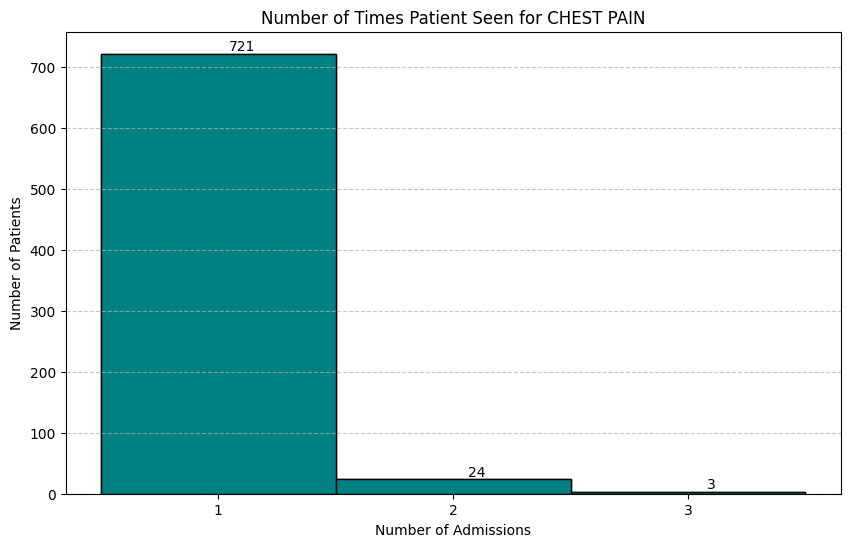

In [141]:
"""Visualization 4: Bar graph displaying frequency of admission for diagnosis of interest"""
# Filter data for the diagnosis 'CHEST PAIN'
specified_diag_df = admissions[admissions['diagnosis'] == diag_of_interest]

# Count the number of admissions per patient
readmission_counts = specified_diag_df.groupby('subject_id').size().reset_index(name='readmission_count')

# Plot the distribution of readmission counts
plt.figure(figsize=(10, 6))
bars = plt.hist(readmission_counts['readmission_count'], bins=range(1, readmission_counts['readmission_count'].max() + 2), align='left', color='teal', edgecolor='black')

plt.hist(readmission_counts['readmission_count'], bins=range(1, readmission_counts['readmission_count'].max() + 2), align='left', color='teal', edgecolor='black')
plt.title(f'Number of Times Patient Seen for {diag_of_interest}')
plt.xlabel('Number of Admissions')
plt.ylabel('Number of Patients')
plt.xticks(range(1, readmission_counts['readmission_count'].max() + 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate bars with the count
for i in range(len(bars[0])):
    plt.text(bars[1][i] + 0.1, bars[0][i] + 0.1, str(int(bars[0][i])), ha='center', va='bottom')

plt.show()


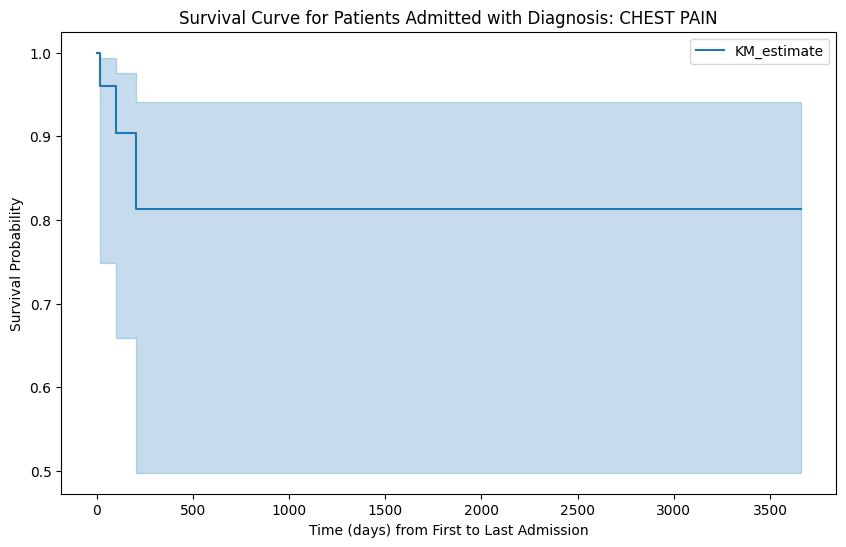

In [142]:
"""Visualization 5: KM curve showing estimated survival probability over time for patients re-admitted for diagnosis of interest"""
duplicate_diagnoses = duplicate_diagnoses[duplicate_diagnoses['diagnosis'] == diag_of_interest]

grouped_diagnoses = duplicate_diagnoses.groupby(['subject_id', 'diagnosis']).agg(
    first_admittime=('admittime', 'min'),
    last_admittime=('admittime', 'max'),
    death_count=('deathtime', lambda x: x.notna().sum()),  # Count deaths for each diagnosis
    survival_count=('deathtime', lambda x: x.isna().sum())  # Count survivals for each diagnosis
).reset_index()

# Calculate the time difference between first and last admissions in days
grouped_diagnoses['time_to_last_event'] = (grouped_diagnoses['last_admittime'] - grouped_diagnoses['first_admittime']).dt.total_seconds() / (60 * 60 * 24)

# Flag whether the patient survived or died (1 for death, 0 for survival)
grouped_diagnoses['event'] = grouped_diagnoses['death_count'].apply(lambda x: 1 if x > 0 else 0)

# Fit the Kaplan-Meier survival curve
kmf = KaplanMeierFitter()

# Get the time durations and event flags for the analysis
T = grouped_diagnoses['time_to_last_event']  # Duration from first to last event
E = grouped_diagnoses['event']               # 1 if death, 0 if survived

# Fit the survival data and plot the survival curve
kmf.fit(T, event_observed=E)

# Plot the Kaplan-Meier survival curve
plt.figure(figsize=(10, 6))
kmf.plot_survival_function()
plt.title(f'Survival Curve for Patients Admitted with Diagnosis: {diag_of_interest}')
plt.xlabel('Time (days) from First to Last Admission')
plt.ylabel('Survival Probability')
plt.show()